In [1]:
%pip install tensorflow keras numpy pandas matplotlib scikit-learn keras-tuner building_footprint_segmentation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model using SynthZero method:
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Seen classes: ['Single', 'Commercial', 'Multi', 'High', 'Hospital', 'Schools']
Unseen classes: ['Industrial']
Total duplicates found and removed: 0
Total duplicates found and removed: 0
Training with seen classes: ['Single', 'Commercial', 'Multi', 'High', 'Hospital', 'Schools']
Testing with unseen classes: ['Industrial']
Total real training images (seen classes): 1321
Total testing images (unseen classes): 214
Generated 500 synthetic images for unseen classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - ac

Model saved at /content/drive/MyDrive/Densenet201_synthzero_model.h5.


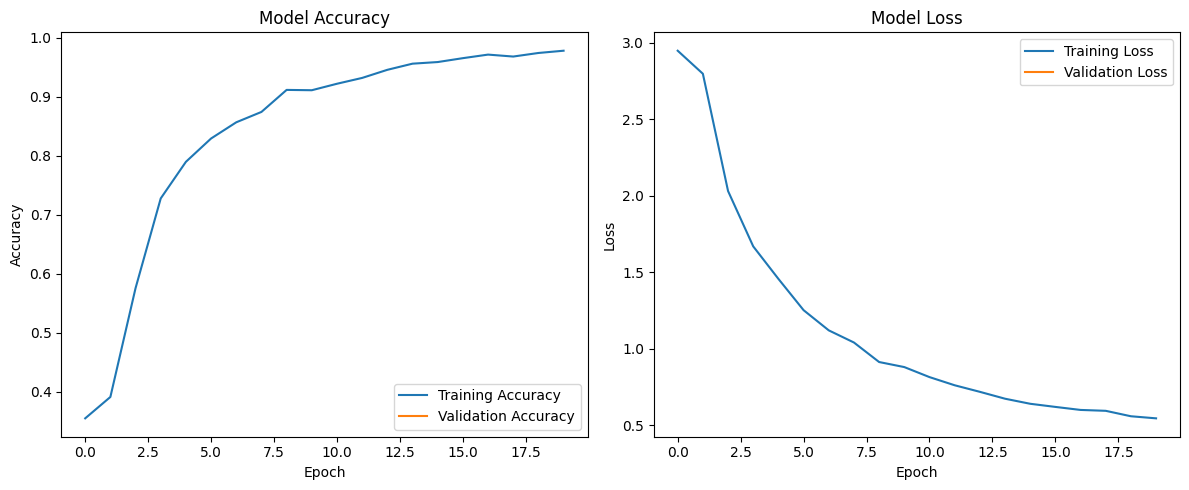

7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.0388 - loss: 4.0388
Test Accuracy on Unseen Classes: 4.2056%
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step
Confusion Matrix:
 [[  9  30 110  32   1   2  30]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
Classification Report:
               precision    recall  f1-score   support

  Industrial       1.00      0.04      0.08       214
      Single       0.00      0.00      0.00         0
  Commercial       0.00      0.00      0.00         0
       Multi       0.00      0.00      0.00         0
        High       0.00      0.00      0.00         0
    Hospital       0.00      0.00      0.00         0
     Schools       0.00      0.00      0.00         0

    accuracy                           0.04       214
   macro avg       0.14      0.01      0.01       214
weighted avg       1.00      0.04      0.08     

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import logging
import hashlib
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'

# Function to get class names from training directories and split into seen and unseen classes
def get_class_names(directories, unseen_class_ratio=0.2):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    # Randomly split classes into seen and unseen
    random.shuffle(class_names)
    num_unseen = int(len(class_names) * unseen_class_ratio)
    unseen_classes = class_names[:num_unseen]
    seen_classes = class_names[num_unseen:]
    print(f"Seen classes: {seen_classes}")
    print(f"Unseen classes: {unseen_classes}")
    logging.info(f"Seen classes: {seen_classes}")
    logging.info(f"Unseen classes: {unseen_classes}")
    return class_names, seen_classes, unseen_classes

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names, classes_to_collect, class_indices):
    image_paths = []
    labels = []
    image_hashes = set()
    duplicate_count = 0

    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in classes_to_collect:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist in '{data_directory}'. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        # Compute hash of the image
                        with open(img_path, 'rb') as f:
                            img_hash = hashlib.md5(f.read()).hexdigest()
                        # Check if the image is a duplicate
                        if img_hash in image_hashes:
                            duplicate_count += 1
                            logging.info(f"Duplicate image found and skipped: {img_path}")
                            continue  # Skip duplicate image
                        image_hashes.add(img_hash)
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
                    except Exception as e:
                        logging.error(f"Error processing image {img_path}: {e}")
    print(f"Total duplicates found and removed: {duplicate_count}")
    logging.info(f"Total duplicates found and removed: {duplicate_count}")
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0  # Normalize to [0,1]
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        return np.zeros((*img_size, 3), dtype=np.float32)  # Return a black image in case of error

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Function to create datasets from image paths
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to create datasets from images in memory
def create_dataset_from_images(images, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    for layer in base_model.layers[:500]:
        layer.trainable = False
    for layer in base_model.layers[500:]:
        layer.trainable = True

    # Input layer
    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = inputs
    x = base_model(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)

    # Compile the model
    optimizer = Adam(learning_rate=5e-5)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('loss', []), label='Training Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to print class counts
def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for class_index, class_name in enumerate(class_names):
        count = counts.get(class_index, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")

# Placeholder function to generate synthetic images for unseen classes
def generate_synthetic_images(unseen_classes, num_images_per_class, class_indices):
    synthetic_images = []
    synthetic_labels = []
    for class_name in unseen_classes:
        class_index = class_indices[class_name]
        for _ in range(num_images_per_class):
            # Placeholder: Generate synthetic image using random noise
            image = np.random.rand(img_size[0], img_size[1], 3).astype(np.float32)
            synthetic_images.append(image)
            synthetic_labels.append(class_index)
    return synthetic_images, synthetic_labels

# Function to train and evaluate the model using SynthZero method
def train_and_evaluate(train_dirs, img_size=(224, 224), batch_size=32, epochs=20):
    # Get class names and split into seen and unseen classes
    class_names, seen_classes, unseen_classes = get_class_names(train_dirs, unseen_class_ratio=0.2)
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    num_classes = len(class_names)

    # Collect real images for seen classes (training data)
    train_image_paths, train_labels = collect_data_paths(train_dirs, class_names, seen_classes, class_indices)

    # Collect real images for unseen classes (testing data)
    test_image_paths, test_labels = collect_data_paths(train_dirs, class_names, unseen_classes, class_indices)

    print(f"Training with seen classes: {seen_classes}")
    print(f"Testing with unseen classes: {unseen_classes}")
    logging.info(f"Training with seen classes: {seen_classes}")
    logging.info(f"Testing with unseen classes: {unseen_classes}")

    print(f"Total real training images (seen classes): {len(train_image_paths)}")
    print(f"Total testing images (unseen classes): {len(test_image_paths)}")
    logging.info(f"Total real training images (seen classes): {len(train_image_paths)}")
    logging.info(f"Total testing images (unseen classes): {len(test_image_paths)}")

    # Generate synthetic images for unseen classes
    num_synthetic_images_per_class = 500  # Adjust as needed
    # Placeholder synthetic image generation
    synthetic_images, synthetic_labels = generate_synthetic_images(unseen_classes, num_synthetic_images_per_class, class_indices)
    print(f"Generated {len(synthetic_images)} synthetic images for unseen classes.")
    logging.info(f"Generated {len(synthetic_images)} synthetic images for unseen classes.")

    # Create training dataset from real images
    train_dataset = create_dataset(train_image_paths, train_labels, training=True)

    # Create synthetic dataset from synthetic images
    synthetic_dataset = create_dataset_from_images(synthetic_images, synthetic_labels, training=True)

    # Combine real and synthetic datasets
    train_dataset = train_dataset.concatenate(synthetic_dataset)

    # Create test dataset from real images of unseen classes
    test_dataset = create_dataset(test_image_paths, test_labels, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=1e-6)

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Densenet201_synthzero_model.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset (unseen classes)
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy on Unseen Classes: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy on Unseen Classes: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [existing_train_dir]

    print("\nTraining model using SynthZero method:")
    logging.info("Starting model training using SynthZero method.")
    test_accuracy = train_and_evaluate(train_dirs, img_size=img_size, batch_size=batch_size, epochs=20)

    print(f"\nFinal Test Accuracy on Unseen Classes: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy on Unseen Classes: {test_accuracy:.4%}")


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total duplicates found and removed: 0
Balancing classes to have 201 images each.
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total images collected: 1407
Training images: 1125
Temp images (for validation and testing): 282
Validation images: 141
Test images: 141

Dataset: Training set
Class: Commercial, Number of images: 161
Class: High, Number of images: 161
Class: Hospital, Number of images: 161
Class: Industrial, Number of images: 160
Class: Multi, Number of images: 161
Class: Schools, Number of image

Model saved at /content/drive/MyDrive/Densenet201_combined_newdata.h5.


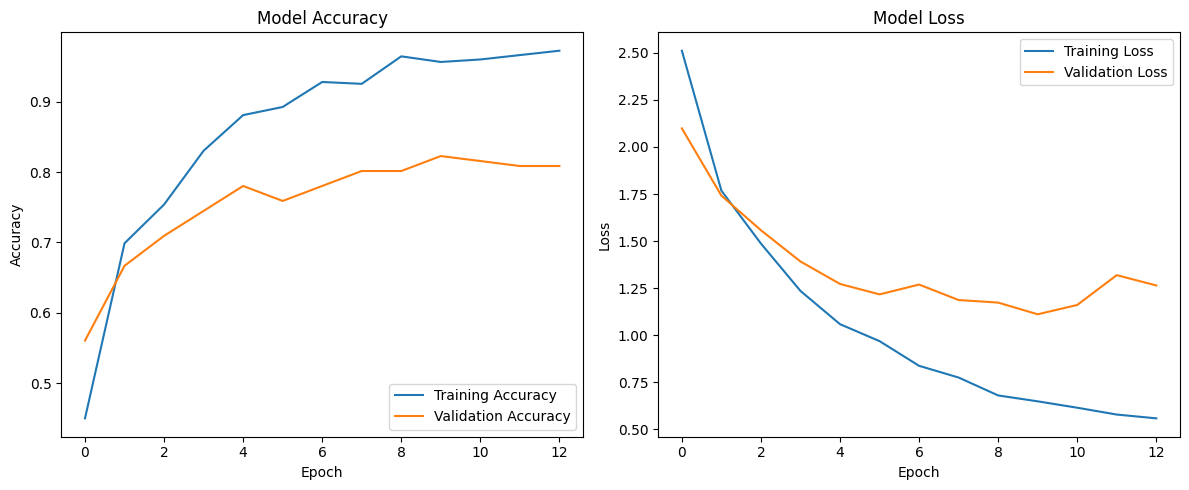

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.8598 - loss: 0.9011
Test Accuracy: 87.2340%
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step
Confusion Matrix:
 [[12  1  0  0  6  1  0]
 [ 0 19  0  1  0  0  0]
 [ 0  0 18  1  0  1  0]
 [ 0  0  0 20  1  0  0]
 [ 1  0  1  0 18  0  0]
 [ 0  0  2  0  1 17  0]
 [ 0  0  1  0  0  0 19]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       0.92      0.60      0.73        20
        High       0.95      0.95      0.95        20
    Hospital       0.82      0.90      0.86        20
  Industrial       0.91      0.95      0.93        21
       Multi       0.69      0.90      0.78        20
     Schools       0.89      0.85      0.87        20
      Single       1.00      0.95      0.97        20

    accuracy                           0.87       141
   macro avg       0.88      0.87      0.87       141
weighted avg       0.88      0.87      0.87       141


Final Test Accuracy: 87.2340%


In [5]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import logging
import hashlib
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split  # Added for data splitting


from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size
img_size = (512, 512)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/Madhu RA Work Folder/newdata'
new_data_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    image_hashes = set()
    duplicate_count = 0

    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist in '{data_directory}'. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        # Compute hash of the image
                        with open(img_path, 'rb') as f:
                            img_hash = hashlib.md5(f.read()).hexdigest()
                        # Check if the image is a duplicate
                        if img_hash in image_hashes:
                            duplicate_count += 1
                            logging.info(f"Duplicate image found and skipped: {img_path}")
                            continue  # Skip duplicate image
                        image_hashes.add(img_hash)
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
                    except Exception as e:
                        logging.error(f"Error processing image {img_path}: {e}")
    print(f"Total duplicates found and removed: {duplicate_count}")
    logging.info(f"Total duplicates found and removed: {duplicate_count}")
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0  # Normalize to [0,1]
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        return np.zeros((*img_size, 3), dtype=np.float32)  # Return a black image in case of error

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    # Use automatic mixed precision without LossScaleOptimizer
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    for layer in base_model.layers[:500]:
        layer.trainable = False
    for layer in base_model.layers[500:]:
        layer.trainable = True

    # Input layer
    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = inputs
    x = base_model(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)

    # Compile the model without LossScaleOptimizer
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# **New function to print class counts**
from collections import Counter

def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for class_index, class_name in enumerate(class_names):
        count = counts.get(class_index, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")

def balance_dataset(image_paths, labels):
    from collections import defaultdict
    random.seed(42)  # For reproducibility

    # Group image paths by class label
    class_to_images = defaultdict(list)
    for img_path, label in zip(image_paths, labels):
        class_to_images[label].append(img_path)

    # Find the minimum number of images in any class
    min_count = min(len(img_list) for img_list in class_to_images.values())
    print(f"Balancing classes to have {min_count} images each.")
    logging.info(f"Balancing classes to have {min_count} images each.")

    # For each class, randomly sample min_count images
    balanced_image_paths = []
    balanced_labels = []
    for label, img_list in class_to_images.items():
        sampled_imgs = random.sample(img_list, min_count)
        balanced_image_paths.extend(sampled_imgs)
        balanced_labels.extend([label] * min_count)

    return balanced_image_paths, balanced_labels

def shuffle_data(paths, labels):
    combined = list(zip(paths, labels))
    random.shuffle(combined)
    paths[:], labels[:] = zip(*combined)
    return list(paths), list(labels)

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(512, 512), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)
    all_image_paths, all_labels = balance_dataset(all_image_paths, all_labels)

    # Split data per class
    from collections import defaultdict

    class_to_images = defaultdict(list)
    for img_path, label in zip(all_image_paths, all_labels):
        class_to_images[label].append(img_path)

    train_paths, train_labels = [], []
    val_paths, val_labels = [], []
    test_paths, test_labels = [], []

    for label, images in class_to_images.items():
        np.random.shuffle(images)
        n_total = len(images)
        n_train = int(0.8 * n_total)
        n_val = int(0.1 * n_total)
        n_test = n_total - n_train - n_val

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]

        train_paths.extend(train_imgs)
        train_labels.extend([label] * len(train_imgs))

        val_paths.extend(val_imgs)
        val_labels.extend([label] * len(val_imgs))

        test_paths.extend(test_imgs)
        test_labels.extend([label] * len(test_imgs))

    # Shuffle the datasets
    train_paths, train_labels = shuffle_data(train_paths, train_labels)
    val_paths, val_labels = shuffle_data(val_paths, val_labels)
    test_paths, test_labels = shuffle_data(test_paths, test_labels)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")
    logging.info(f"Training with classes: {class_names}")

    print(f"Total images collected: {len(all_image_paths)}")
    logging.info(f"Total images collected: {len(all_image_paths)}")

    # Split the data into train (90%) and temp (10%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    print(f"Training images: {len(train_paths)}")
    print(f"Temp images (for validation and testing): {len(temp_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Temp images (for validation and testing): {len(temp_paths)}")

    # Further split temp into validation (5%) and test (5%)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    # **Print class counts for each dataset**
    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    # Create datasets
    train_dataset = create_dataset(train_paths, train_labels, training=True)
    val_dataset = create_dataset(val_paths, val_labels, training=False)
    test_dataset = create_dataset(test_paths, test_labels, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Densenet201_combined_newdata.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [new_data_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(train_dirs, img_size=img_size, batch_size=batch_size, epochs=20)

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")


In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split  # Added for data splitting
from PIL import Image
import matplotlib.pyplot as plt  # Import for plotting training history
import logging  # Added for logging

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/Madhu RA Work Folder/newdata'
new_data_dir = '/content/drive/MyDrive/ML/Model/train'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    image_paths.append(img_path)
                    labels.append(class_indices[class_name])
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0  # Normalize to [0,1]
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        raise tf.errors.InvalidArgumentError(None, None, f"Error loading image {filename}")

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
    tf.keras.layers.RandomContrast(factor=0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    with tf.device('/GPU:0'):
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        for layer in base_model.layers[:500]:
            layer.trainable = False
        for layer in base_model.layers[500:]:
            layer.trainable = True

        # Input layer
        inputs = Input(shape=(img_size[0], img_size[1], 3))
        x = inputs
        x = base_model(x, training=True)
        x = GlobalAveragePooling2D()(x)
        x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Added L2 regularization
        x = Dropout(0.5)(x)  # Increased dropout rate to 0.5
        outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

        model = Model(inputs, outputs)

        # Compile the model
        optimizer = Adam(learning_rate=5e-5)  # Adjusted learning rate
        optimizer = mixed_precision.LossScaleOptimizer(optimizer)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# **New function to print class counts**
from collections import Counter

def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for class_index, class_name in enumerate(class_names):
        count = counts.get(class_index, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(224, 224), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")
    logging.info(f"Training with classes: {class_names}")

    print(f"Total images collected: {len(all_image_paths)}")
    logging.info(f"Total images collected: {len(all_image_paths)}")

    # Split the data into train (90%) and temp (10%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    print(f"Training images: {len(train_paths)}")
    print(f"Temp images (for validation and testing): {len(temp_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Temp images (for validation and testing): {len(temp_paths)}")

    # Further split temp into validation (5%) and test (5%)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    # **Print class counts for each dataset**
    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    # Create datasets
    train_dataset = create_dataset(train_paths, train_labels, training=True)
    val_dataset = create_dataset(val_paths, val_labels, training=False)
    test_dataset = create_dataset(test_paths, test_labels, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_fulllarge.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [existing_train_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(train_dirs, img_size=img_size, batch_size=batch_size, epochs=20)

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/Madhu RA Work Folder/newdata': ['Schools', 'Single', 'Commercial', 'Industrial', 'Multi', 'Hospital', 'High']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total images collected: 9976
Training images: 7980
Temp images (for validation and testing): 1996
Validation images: 998
Test images: 998

Dataset: Training set
Class: Commercial, Number of images: 1552
Class: High, Number of images: 329
Class: Hospital, Number of images: 61
Class: Industrial, Number of images: 1285
Class: Multi, Number of images: 1600
Class: Schools, Number of images: 1553
Class: Single, Number of images: 1600



Dataset: Validation set
Class: Commercial, Number of images: 194
Cl

KeyboardInterrupt: 

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total duplicates found and removed: 0
Found 1381 validated image filenames belonging to 7 classes.
Found 77 validated image filenames belonging to 7 classes.
Found 77 validated image filenames belonging to 7 classes.

Dataset: Training set
Class: Commercial, Number of images: 182
Class: High, Number of images: 263
Class: Hospital, Number of images: 181
Class: Industrial, Number of images: 192
Class: Multi, Number of images: 195
Class: Schools, Number of images: 184
Class: Single, Number of images: 184



Dataset: Validation set
Class: Commercial, Number of ima

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 283s 4s/step - accuracy: 0.3423 - loss: 2.8051 - val_accuracy: 0.5844 - val_loss: 1.9387 - learning_rate: 1.0000e-04
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7110 - loss: 1.7453 - val_accuracy: 0.6753 - val_loss: 1.6940 - learning_rate: 1.0000e-04
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7945 - loss: 1.4295 - val_accuracy: 0.7662 - val_loss: 1.5252 - learning_rate: 1.0000e-04
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8267 - loss: 1.1906 - val_accuracy: 0.8312 - val_loss: 1.2315 - learning_rate: 1.0000e-04
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8780 - loss: 1.0433 - val_accuracy: 0.8312 - val_loss: 1.2398 - learning_rate: 1.0000e-04
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8919 - loss: 0.8858 - val_accuracy: 0.8571 - val_loss: 0.9779 - learning_rate: 1.0000e-04
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9280 - loss: 0.7984 - 

Model saved at /content/drive/MyDrive/Densenet201_combined_newdat8a.h5.


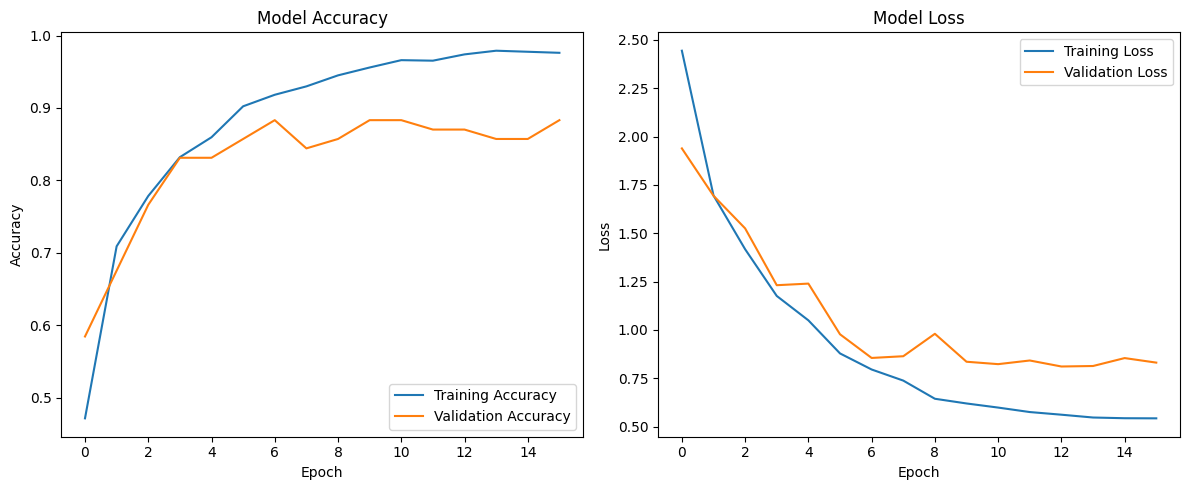

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.8296 - loss: 0.7901
Test Accuracy: 83.1169%
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step


ValueError: Mix of label input types (string and number)

In [7]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
import matplotlib.pyplot as plt

# Set mixed precision policy
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size
img_size = (512, 512)
batch_size = 32

# Set the base directories for the data
new_data_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: class_name for class_name in class_names}
    image_hashes = set()
    duplicate_count = 0

    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist in '{data_directory}'. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        # Compute hash of the image
                        with open(img_path, 'rb') as f:
                            img_hash = hash(f.read())
                        # Check if the image is a duplicate
                        if img_hash in image_hashes:
                            duplicate_count += 1
                            logging.info(f"Duplicate image found and skipped: {img_path}")
                            continue  # Skip duplicate image
                        image_hashes.add(img_hash)
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
                    except Exception as e:
                        logging.error(f"Error processing image {img_path}: {e}")
    print(f"Total duplicates found and removed: {duplicate_count}")
    logging.info(f"Total duplicates found and removed: {duplicate_count}")
    return image_paths, labels

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    for layer in base_model.layers[:500]:
        layer.trainable = False
    for layer in base_model.layers[500:]:
        layer.trainable = True

    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = inputs
    x = base_model(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Data augmentation using Keras ImageDataGenerator
def create_data_generator(image_paths, labels, training=True):
    labels = np.array(labels)
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ) if training else ImageDataGenerator(rescale=1.0/255.0)

    dataframe = pd.DataFrame({'filename': image_paths, 'class': labels})
    dataset = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=training  # Ensure shuffle=False for validation and test datasets
    )
    return dataset

# Function to print class counts
def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for class_index, class_name in enumerate(class_names):
        count = counts.get(class_name, 0)  # Convert class_index to string to match label format
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")
    logging.info("\n")

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(512, 512), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)

    # Split the data into train, validation, and test sets (10% test)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.1, stratify=all_labels, random_state=42
    )
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )

    # Create training, validation, and test datasets
    train_dataset = create_data_generator(train_paths, train_labels, training=True)
    val_dataset = create_data_generator(val_paths, val_labels, training=False)
    test_dataset = create_data_generator(test_paths, test_labels, training=False)  # shuffle=False

    # Print class counts for each dataset
    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    # Build the model
    num_classes = len(class_names)
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Densenet201_combined_newdat8a.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # **Use test_labels directly as y_true**
    y_true = np.array(test_labels)

    # **Generate predictions**
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [new_data_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(train_dirs, img_size=img_size, batch_size=batch_size, epochs=20)

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")


In [6]:
import os
import random
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability and set memory growth before any TensorFlow operations
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
    try:
        # Allow TensorFlow to only allocate memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"Error setting memory growth: {e}")
        logging.error(f"Error setting memory growth: {e}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Now import other TensorFlow modules after setting memory growth
# Set seeds for TensorFlow after importing
tf.random.set_seed(42)

# Enable mixed precision policy
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Enable XLA (Accelerated Linear Algebra) for better performance
tf.config.optimizer.set_jit(True)

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation,
    RandomZoom, RandomContrast, RandomBrightness
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter

# Set the image size and batch size
img_size = (256, 256)  # Adjust as needed
batch_size = 64        # Adjust based on your GPU memory

# Set the base directory for the data
new_data_dir = '/content/drive/MyDrive/Madhu RA Work Folder/newdata'  # Replace with your data path

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory)
                          if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    # Correctly map class names to indices
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    image_hashes = set()
    duplicate_count = 0

    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist in '{data_directory}'. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        # Compute hash of the image
                        with open(img_path, 'rb') as f:
                            img_hash = hash(f.read())
                        # Check if the image is a duplicate
                        if img_hash in image_hashes:
                            duplicate_count += 1
                            logging.info(f"Duplicate image found and skipped: {img_path}")
                            continue  # Skip duplicate image
                        image_hashes.add(img_hash)
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])  # Use class index
                    except Exception as e:
                        logging.error(f"Error processing image {img_path}: {e}")
    print(f"Total duplicates found and removed: {duplicate_count}")
    logging.info(f"Total duplicates found and removed: {duplicate_count}")
    print(f"Total images collected: {len(image_paths)}")
    logging.info(f"Total images collected: {len(image_paths)}")
    return image_paths, labels

# Function to print class counts
def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for idx, class_name in enumerate(class_names):
        count = counts.get(idx, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")
    logging.info("\n")

# Function to build the model with data augmentation layers
def build_model(num_classes):
    # Data augmentation layers
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomContrast(0.1),
        RandomBrightness(0.1)
    ])

    base_model = DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )
    base_model.trainable = False  # Freeze base model

    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Function to create a TensorFlow dataset
def create_tf_dataset(image_paths, labels, training=True):
    AUTOTUNE = tf.data.AUTOTUNE

    def load_and_preprocess(image_path, label):
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=3, expand_animations=False)
            image = tf.image.resize(image, img_size)
            image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
            return image, label
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            logging.error(f"Error processing image {image_path}: {e}")
            # Return a zero image if there's an error
            image = tf.zeros([img_size[0], img_size[1], 3], dtype=tf.float32)
            return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if training:
        dataset = dataset.shuffle(buffer_size=10000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(256, 256), batch_size=64, epochs=20):
    class_names = get_class_names(train_dirs)
    num_classes = len(class_names)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)

    # Verify that images have been collected
    if len(all_image_paths) == 0:
        print("No images found. Please check your data directories and file formats.")
        logging.error("No images found. Exiting training.")
        return

    # Split the data into train, validation, and test sets (10% test)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.1, stratify=all_labels, random_state=42
    )
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )

    # Create training, validation, and test datasets
    train_dataset = create_tf_dataset(train_paths, train_labels, training=True)
    val_dataset = create_tf_dataset(val_paths, val_labels, training=False)
    test_dataset = create_tf_dataset(test_paths, test_labels, training=False)

    # Print class counts for each dataset
    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    # Build the model
    strategy = tf.distribute.MirroredStrategy()  # For multi-GPU support
    with strategy.scope():
        model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Densenet201_combined_newdata.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Convert test_labels to numpy array
    y_true = np.array(test_labels)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(
        y_true,
        y_pred,
        labels=range(num_classes),
        target_names=class_names,
        zero_division=0
    )
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [new_data_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(
        train_dirs, img_size=img_size, batch_size=batch_size, epochs=20
    )

    if test_accuracy is not None:
        print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
        logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")
    else:
        print("Training was not completed due to errors.")
        logging.error("Training was not completed due to errors.")


ERROR:root:Error setting memory growth: Physical devices cannot be modified after being initialized


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Error setting memory growth: Physical devices cannot be modified after being initialized

Training model with combined training data:
Classes in '/content/drive/MyDrive/Madhu RA Work Folder/newdata': ['Schools', 'Single', 'Commercial', 'Industrial', 'Multi', 'Hospital', 'High']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total duplicates found and removed: 0
Total images collected: 13605

Dataset: Training set
Class: Commercial, Number of images: 1746
Class: High, Number of images: 1800
Class: Hospital, Number of images: 1705
Class: Industrial, Number of images: 1646
Class: Multi, Number of images: 1800
Class: Schools, Number of images: 1747
Class: Single, Number of images: 1800



Dataset: Validation set
Class: Commercial, Number of images: 97
Class: High, Number of images: 100
Class: Hospital, Number of images: 95
Class: Ind

InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Error in user-defined function passed to ParallelMapDatasetV2:62 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[MultiDeviceIteratorGetNextFromShard]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
	 [[OptionalHasValue/_6]]
  (1) INVALID_ARGUMENT:  Error in user-defined function passed to ParallelMapDatasetV2:62 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[MultiDeviceIteratorGetNextFromShard]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_254430]

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/Madhu RA Work Folder/newdata': ['Schools', 'Single', 'Commercial', 'Industrial', 'Multi', 'Hospital', 'High']
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total duplicates found and removed: 0
Total images collected: 15140
Balancing classes to have 2043 images each.
Training images: 11440
Validation images: 1430
Test images: 1431

Dataset: Training set
Class: Commercial, Number of images: 1635
Class: High, Number of images: 1635
Class: Hospital, Number of images: 1634
Class: Industrial, Number of images: 1634
Class: Multi, Number of images: 1634
Class: Schools, Number o

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/358 ━━━━━━━━━━━━━━━━━━━━ 895s 2s/step - accuracy: 0.4884 - loss: 2.2361 - val_accuracy: 0.6434 - val_loss: 1.4850 - learning_rate: 1.0000e-04
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 694s 2s/step - accuracy: 0.6715 - loss: 1.3871 - val_accuracy: 0.7294 - val_loss: 1.1895 - learning_rate: 1.0000e-04
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - accuracy: 0.7269 - loss: 1.1832 - val_accuracy: 0.7329 - val_loss: 1.1095 - learning_rate: 1.0000e-04
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.7682 - loss: 1.0476 - val_accuracy: 0.7350 - val_loss: 1.1807 - learning_rate: 1.0000e-04
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.7971 - loss: 0.9298 - val_accuracy: 0.7706 - val_loss: 1.0578 - learning_rate: 1.0000e-04
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - accuracy: 0.8261 - loss: 0.8182 - val_accuracy: 0.7615 - val_loss: 1.0905 - learning_rate: 1.0000e-04
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.84

Model saved at /content/drive/MyDrive/Densenet201_combined_newdata.h5.


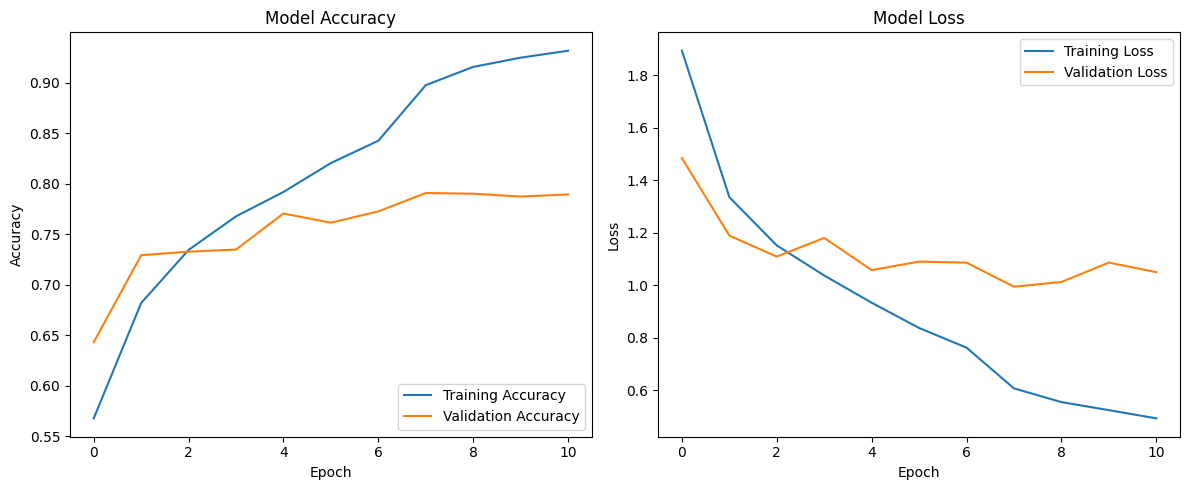

45/45 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7707 - loss: 1.1260
Test Accuracy: 77.9874%
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 766ms/step
Confusion Matrix:
 [[147   4   9  17  11  15   1]
 [ 12 154  13   8   5   9   3]
 [ 20   5 143   9   2  24   2]
 [ 33   2   2 153   1  12   1]
 [  8   6   6   1 180   1   3]
 [ 19   4  15  17   4 144   2]
 [  3   0   2   1   1   2 195]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       0.61      0.72      0.66       204
        High       0.88      0.75      0.81       204
    Hospital       0.75      0.70      0.72       205
  Industrial       0.74      0.75      0.75       204
       Multi       0.88      0.88      0.88       205
     Schools       0.70      0.70      0.70       205
      Single       0.94      0.96      0.95       204

    accuracy                           0.78      1431
   macro avg       0.79      0.78      0.78      1431
weighted avg       0.79      0.78      0.78      1431


Fi

In [9]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
import matplotlib.pyplot as plt
import hashlib

# Set mixed precision policy
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size (from Code 2)
img_size = (512, 512)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/Madhu RA Work Folder/newdata'  # Replace with your path
new_data_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'  # Replace with your path

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    # Correctly map class names to indices
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    image_hashes = set()
    duplicate_count = 0

    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist in '{data_directory}'. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        # Compute hash of the image
                        with open(img_path, 'rb') as f:
                            img_hash = hashlib.md5(f.read()).hexdigest()
                        # Check if the image is a duplicate
                        if img_hash in image_hashes:
                            duplicate_count += 1
                            logging.info(f"Duplicate image found and skipped: {img_path}")
                            continue  # Skip duplicate image
                        image_hashes.add(img_hash)
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
                    except Exception as e:
                        logging.error(f"Error processing image {img_path}: {e}")
    print(f"Total duplicates found and removed: {duplicate_count}")
    logging.info(f"Total duplicates found and removed: {duplicate_count}")
    print(f"Total images collected: {len(image_paths)}")
    logging.info(f"Total images collected: {len(image_paths)}")
    return image_paths, labels

# Function to balance the dataset
def balance_dataset(image_paths, labels):
    from collections import defaultdict
    random.seed(42)  # For reproducibility

    # Group image paths by class label
    class_to_images = defaultdict(list)
    for img_path, label in zip(image_paths, labels):
        class_to_images[label].append(img_path)

    # Find the minimum number of images in any class
    min_count = min(len(img_list) for img_list in class_to_images.values())
    print(f"Balancing classes to have {min_count} images each.")
    logging.info(f"Balancing classes to have {min_count} images each.")

    # For each class, randomly sample min_count images
    balanced_image_paths = []
    balanced_labels = []
    for label, img_list in class_to_images.items():
        sampled_imgs = random.sample(img_list, min_count)
        balanced_image_paths.extend(sampled_imgs)
        balanced_labels.extend([label] * min_count)

    return balanced_image_paths, balanced_labels

# Function to create data generators using ImageDataGenerator
def create_data_generator(image_paths, labels, class_names, training=True):
    labels = np.array(labels)
    # Create a dataframe for flow_from_dataframe
    dataframe = pd.DataFrame({'filename': image_paths, 'class': labels})

    if training:
        datagen = ImageDataGenerator(
            rescale=1.0/255.0,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1.0/255.0)

    dataset = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='raw',  # Use 'raw' to get numerical labels directly
        shuffle=training,
        classes=None  # Ensures that class indices are not altered
    )
    return dataset

# Function to print class counts
def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for idx, class_name in enumerate(class_names):
        count = counts.get(idx, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")
    logging.info("\n")

# Function to build the model with adjusted trainable layers
def build_model(num_classes):
    base_model = DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )

    # Freeze layers up to a certain point for fine-tuning
    for layer in base_model.layers[:500]:
        layer.trainable = False
    for layer in base_model.layers[500:]:
        layer.trainable = True

    # Input layer
    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = inputs
    x = base_model(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)

    # Compile the model
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(512, 512), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)
    num_classes = len(class_names)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)

    # Balance the dataset
    all_image_paths, all_labels = balance_dataset(all_image_paths, all_labels)

    # Split data into train, validation, and test sets
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )

    # Print dataset sizes
    print(f"Training images: {len(train_paths)}")
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    # Print class counts for each dataset
    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    # Create data generators
    train_dataset = create_data_generator(train_paths, train_labels, class_names, training=True)
    val_dataset = create_data_generator(val_paths, val_labels, class_names, training=False)
    test_dataset = create_data_generator(test_paths, test_labels, class_names, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Densenet201_combined_newdata.h5'  # Replace with your desired path
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = test_dataset.labels
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(
        y_true,
        y_pred,
        labels=range(num_classes),
        target_names=class_names,
        zero_division=0
    )
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [existing_train_dir, new_data_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(
        train_dirs, img_size=img_size, batch_size=batch_size, epochs=20
    )

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total duplicates found and removed: 0
Total images collected: 1535
Balancing classes to have 201 images each.
Training images: 1125
Validation images: 141
Test images: 141

Dataset: Training set
Class: Commercial, Number of images: 161
Class: High, Number of images: 161
Class: Hospital, Number of images: 161
Class: Industrial, Number of images: 160
Class: Multi, Number of images: 161
Class: Schools, Number of images: 161
Class: Single, Number of images: 160



Dataset: Validation set
Class: Commercial, Number of images: 20
Class: High, Number of images: 20
Cla

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.3139 - loss: 2.8225 - val_accuracy: 0.5248 - val_loss: 2.2522 - learning_rate: 1.0000e-04
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6839 - loss: 1.8422 - val_accuracy: 0.5745 - val_loss: 1.8983 - learning_rate: 1.0000e-04
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7662 - loss: 1.5076 - val_accuracy: 0.5957 - val_loss: 1.7018 - learning_rate: 1.0000e-04
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8375 - loss: 1.2629 - val_accuracy: 0.6809 - val_loss: 1.5048 - learning_rate: 1.0000e-04
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8666 - loss: 1.0967 - val_accuracy: 0.6879 - val_loss: 1.4544 - learning_rate: 1.0000e-04
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9135 - loss: 0.9505 - val_accuracy: 0.7234 - val_loss: 1.3866 - learning_rate: 1.0000e-04
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9107 - loss: 0.8672 - 

Model saved at /content/drive/MyDrive/Densenet201_combined_phase2.h5.


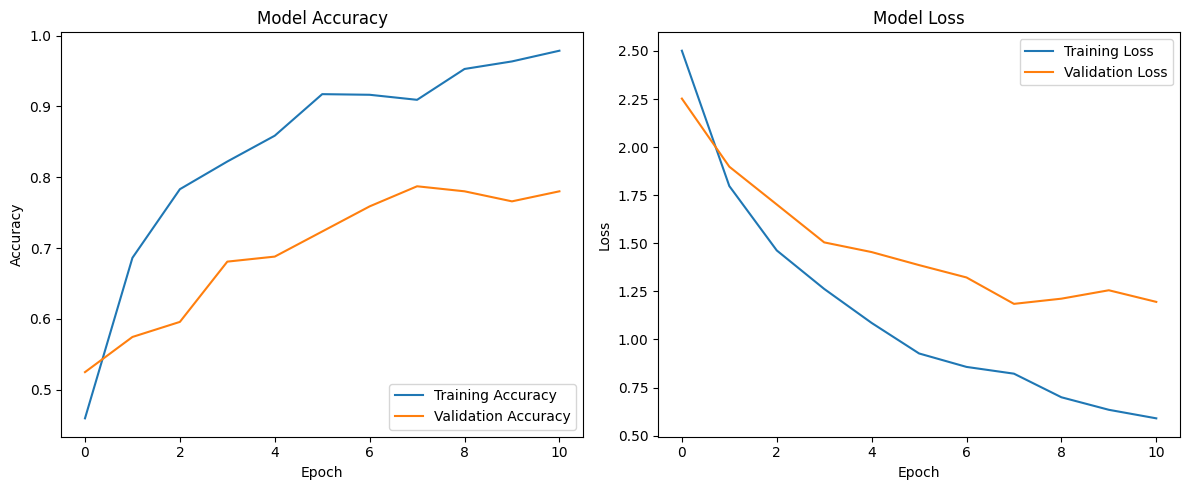

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 0.8632 - loss: 1.0511
Test Accuracy: 88.6525%
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step
Confusion Matrix:
 [[15  0  1  0  3  1  0]
 [ 0 20  0  0  0  0  0]
 [ 0  0 15  1  0  4  0]
 [ 0  0  0 21  0  0  0]
 [ 2  0  1  0 17  0  0]
 [ 1  0  1  0  0 18  0]
 [ 0  0  0  0  0  1 19]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       0.83      0.75      0.79        20
        High       1.00      1.00      1.00        20
    Hospital       0.83      0.75      0.79        20
  Industrial       0.95      1.00      0.98        21
       Multi       0.85      0.85      0.85        20
     Schools       0.75      0.90      0.82        20
      Single       1.00      0.95      0.97        20

    accuracy                           0.89       141
   macro avg       0.89      0.89      0.89       141
weighted avg       0.89      0.89      0.89       141


Final Test Accuracy: 88.6525%


In [10]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
import matplotlib.pyplot as plt
import hashlib

# Set mixed precision policy
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size (from Code 2)
img_size = (512, 512)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/Madhu RA Work Folder/newdata'  # Replace with your path
new_data_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'  # Replace with your path

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    # Correctly map class names to indices
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    image_hashes = set()
    duplicate_count = 0

    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist in '{data_directory}'. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        # Compute hash of the image
                        with open(img_path, 'rb') as f:
                            img_hash = hashlib.md5(f.read()).hexdigest()
                        # Check if the image is a duplicate
                        if img_hash in image_hashes:
                            duplicate_count += 1
                            logging.info(f"Duplicate image found and skipped: {img_path}")
                            continue  # Skip duplicate image
                        image_hashes.add(img_hash)
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
                    except Exception as e:
                        logging.error(f"Error processing image {img_path}: {e}")
    print(f"Total duplicates found and removed: {duplicate_count}")
    logging.info(f"Total duplicates found and removed: {duplicate_count}")
    print(f"Total images collected: {len(image_paths)}")
    logging.info(f"Total images collected: {len(image_paths)}")
    return image_paths, labels

# Function to balance the dataset
def balance_dataset(image_paths, labels):
    from collections import defaultdict
    random.seed(42)  # For reproducibility

    # Group image paths by class label
    class_to_images = defaultdict(list)
    for img_path, label in zip(image_paths, labels):
        class_to_images[label].append(img_path)

    # Find the minimum number of images in any class
    min_count = min(len(img_list) for img_list in class_to_images.values())
    print(f"Balancing classes to have {min_count} images each.")
    logging.info(f"Balancing classes to have {min_count} images each.")

    # For each class, randomly sample min_count images
    balanced_image_paths = []
    balanced_labels = []
    for label, img_list in class_to_images.items():
        sampled_imgs = random.sample(img_list, min_count)
        balanced_image_paths.extend(sampled_imgs)
        balanced_labels.extend([label] * min_count)

    return balanced_image_paths, balanced_labels

# Function to create data generators using ImageDataGenerator
def create_data_generator(image_paths, labels, class_names, training=True):
    labels = np.array(labels)
    # Create a dataframe for flow_from_dataframe
    dataframe = pd.DataFrame({'filename': image_paths, 'class': labels})

    if training:
        datagen = ImageDataGenerator(
            rescale=1.0/255.0,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1.0/255.0)

    dataset = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='raw',  # Use 'raw' to get numerical labels directly
        shuffle=training,
        classes=None  # Ensures that class indices are not altered
    )
    return dataset

# Function to print class counts
def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for idx, class_name in enumerate(class_names):
        count = counts.get(idx, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")
    logging.info("\n")

# Function to build the model with adjusted trainable layers
def build_model(num_classes):
    base_model = DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )

    # Freeze layers up to a certain point for fine-tuning
    for layer in base_model.layers[:500]:
        layer.trainable = False
    for layer in base_model.layers[500:]:
        layer.trainable = True

    # Input layer
    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = inputs
    x = base_model(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)

    # Compile the model
    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(512, 512), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)
    num_classes = len(class_names)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)

    # Balance the dataset
    all_image_paths, all_labels = balance_dataset(all_image_paths, all_labels)

    # Split data into train, validation, and test sets
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )

    # Print dataset sizes
    print(f"Training images: {len(train_paths)}")
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    # Print class counts for each dataset
    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    # Create data generators
    train_dataset = create_data_generator(train_paths, train_labels, class_names, training=True)
    val_dataset = create_data_generator(val_paths, val_labels, class_names, training=False)
    test_dataset = create_data_generator(test_paths, test_labels, class_names, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Densenet201_combined_phase2.h5'  # Replace with your desired path
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = test_dataset.labels
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(
        y_true,
        y_pred,
        labels=range(num_classes),
        target_names=class_names,
        zero_division=0
    )
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [new_data_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(
        train_dirs, img_size=img_size, batch_size=batch_size, epochs=20
    )

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")
